# Correlates of pollution

**Objective**: In this notebook I am going to use linear regression and time series analysis to identify cause of pollution in a big city agglomeration (Paris)

## Introduction

The care for air quality remains one of the challanges for urban enviroments. To control the level of pollutants, the officials introduce policies at national and regional level. Some of these policies regulate the traffic in the urban areas, for example, by restricting the areas to low-emission vehicles or providing incentives to choose public transport (e.g. park&ride systems). To proritise these policies, we need to understand how the traffic and other human activities produce pollution. 

Our goal in this analysis will be to understand the link between pollution and traffic in a big city agglomeration (Paris).

## Traffic in Paris

In [1]:
import geopandas as gpd
import pandas as pd
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

### Read traffic data

The city of Paris (Mairie de Paris) provides free of charge data about traffic measured from sensor embedded in the street surface (electromagnetic loops). More information and the data are availabe at:

https://opendata.paris.fr/explore/dataset/comptages-routiers-permanents/information

For the purpose of this analysis, I downloaded the data from a single year (2018) available as a zip file. After decompressing, we can load the data in CSV format using pandas IO functions:

In [2]:
def read_traffic_month(i):
    return pd.read_csv('./data/donnes_paris_capteurs/donnees_trafic_capteurs_2018%02d.txt' % i, 
                       decimal=b',', sep='\t', 
                       names=['arc_id', 'date', 'debit', 'percent'],
                       parse_dates=True)

datasets = [read_traffic_month(i) for i in range(1, 13)]

trafic = pd.concat(datasets)

trafic['date_parsed'] = pd.to_datetime(trafic['date'])

trafic.head()

,arc_id,date,debit,percent,date_parsed
0,1,2018-01-01 01:00:00,1915.0,8.4,2018-01-01 01:00:00
1,1,2018-01-01 02:00:00,2111.0,8.8,2018-01-01 02:00:00
2,1,2018-01-01 03:00:00,1971.0,8.5,2018-01-01 03:00:00
3,1,2018-01-01 04:00:00,1864.0,6.6,2018-01-01 04:00:00
4,1,2018-01-01 05:00:00,1584.0,6.0,2018-01-01 05:00:00


The traffic data contains the five columns: date in original format and datetime object (`date` and `date_parsed` respectively), the ID of the sensor `arc_id`, the number of cars counted in an hour `debit` and the percent of the time the sensor was occupied by the traffic (`percent`).

### Read sensor positions

Now identify the position of the sensor, we need to load another data file, which contains the geographical coordinates of each sensor. This file is in GeoJSON format that is best read by the pandas extension called `geopandas`. Its API is very similar to vanilla pandas, but it can work with geographical coordinates and primitives (lines, point, areas etc.).


In [3]:
import geopandas as geo

ref = geo.read_file('./data/donnes_paris_capteurs/referentiel-comptages-routiers.geojson')

In [4]:
ref.head()

,id_arc,shape_len,id_arc_tra,objectid,geometry
0,1106.0,0.0,4301,1009,LINESTRING (2.28798041439171 48.88017393472605...
1,1110.0,0.0,5868,1013,LINESTRING (2.40337979871683 48.83660044342846...
2,1114.0,0.0,242,1016,"LINESTRING (2.3237231484805 48.86921363860055,..."
3,1125.0,0.0,1368,1027,LINESTRING (2.366809149811577 48.8631749310459...
4,1126.0,0.0,1366,1028,LINESTRING (2.365875732594472 48.8646639691920...


In [5]:
print(len(ref))

3316


We select the areas of interest using special slicing operator that works with geo coordinates. The we average over the traffic measured by all sensors in the central Paris.

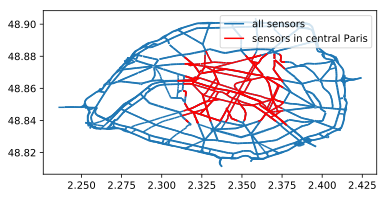

In [6]:
import matplotlib.pyplot as plt
ax = plt.subplot(111)
ref.dropna()
ref.plot(ax=ax, label='all sensors')
ref.dropna().cx[2.315:2.375, 48.84:48.88].plot(color='r', ax=ax, label='sensors in central Paris')
plt.legend()

If you are familiar with Paris layout you will recognise the main motor axes: the peripherique (the roundroad delimiting the boarder of Paris city), the quais of the Seine, the boulevards and avenues.

Now we can calculate and plot the mean traffic in central Paris. You will see that it contains oscillations, which are due to daily rythm of traffic. In addition there are oscillations with longer 7-day period. These can be explained by weekly dynamics. 

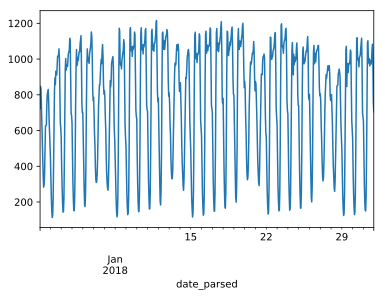

In [7]:
central_paris = ref.dropna()\
                   .cx[2.315:2.375, 48.84:48.88]\
                   .id_arc_tra
mean_trafic = trafic[trafic.arc_id.isin(central_paris.values)]\
                  .groupby('date_parsed')\
                  .mean()

mean_trafic.loc['2018-01-01':'2018-01-31', 'debit'].plot()

There are several ways to remove such periodic trends from the data. We could, for example, average traffic across days or weeks and then subtract the average from the original series. Alternatively, we could try to fit a model for such oscillations. Finally, we could use frequency domain analysis (Fast fourier transform) to zero-out the coefficients related to the oscillations. Here, we will instead calculate a moving average over the time series with the length of the window of 7 days. This way we will effectively average out any weekly/daily fluctuations.

In [8]:
trafic_ma_7days = mean_trafic.loc[:, ['debit', 'percent']].rolling('7D').mean()

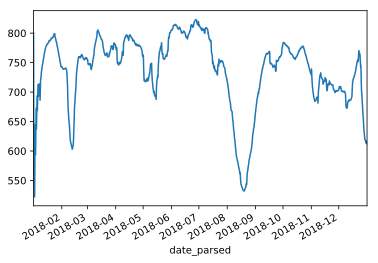

In [9]:
trafic_ma_7days.loc['2018-01-01':'2018-12-31', 'debit'].plot()

## Pollution data

We obtain the pollution data from Airparif service. The data is available in mulitple formats and from multiple sources, but I found the ArcGIS website to be most reliable: 

https://data-airparif-asso.opendata.arcgis.com/datasets/814f8e1550db4852b2c0a79f23c66f9c_0?geometry=2.326%2C48.858%2C2.357%2C48.863

The data is formated as GeoJSON file, which we import using geopandas. However, this time we will use the name of the location (Paris, 4th arrondissement) to select the measurement station, instead of specifing the coordinates.

In [10]:

gdf = gpd.read_file('./data/airparif_2018/airparis.geojson')


In [11]:
paris_center = gdf[gdf['nom_com'] == 'PARIS-4E-ARRONDISSEMENT']

In [12]:
paris_center.head()

,id,nom_dept,nom_com,id_com,nom_station,code_station_ue,typologie,nom_poll,id_poll_ue,valeur,unite,metrique,date_debut,date_fin,statut_valid,x,y,geometry
40541,50542,PARIS,PARIS-4E-ARRONDISSEMENT,75104,PARIS Centre,4143,Urbaine,NO2,8,38.0,ug.m-3,horaire,2017-09-18T16:00:00,2017-09-18T17:00:00,1,652382,6862336,POINT (2.35098445380465 48.85929729959835)
40542,50543,PARIS,PARIS-4E-ARRONDISSEMENT,75104,PARIS Centre,4143,Urbaine,NO2,8,37.0,ug.m-3,horaire,2017-09-18T17:00:00,2017-09-18T18:00:00,1,652382,6862336,POINT (2.35098445380465 48.85929729959835)
40543,50544,PARIS,PARIS-4E-ARRONDISSEMENT,75104,PARIS Centre,4143,Urbaine,NO2,8,44.0,ug.m-3,horaire,2017-09-18T18:00:00,2017-09-18T19:00:00,1,652382,6862336,POINT (2.35098445380465 48.85929729959835)
40544,50545,PARIS,PARIS-4E-ARRONDISSEMENT,75104,PARIS Centre,4143,Urbaine,NO2,8,67.0,ug.m-3,horaire,2017-09-18T19:00:00,2017-09-18T20:00:00,1,652382,6862336,POINT (2.35098445380465 48.85929729959835)
40545,50546,PARIS,PARIS-4E-ARRONDISSEMENT,75104,PARIS Centre,4143,Urbaine,NO2,8,74.0,ug.m-3,horaire,2017-09-18T20:00:00,2017-09-18T21:00:00,1,652382,6862336,POINT (2.35098445380465 48.85929729959835)


We will superimpose the station on the map of sensors that we obtained previously:

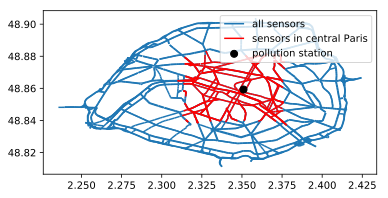

In [13]:
ax = plt.subplot(111)
ref.plot(ax=ax, label='all sensors')
ref.dropna().cx[2.315:2.375, 48.84:48.88].plot(color='r', ax=ax, label='sensors in central Paris')
paris_center.iloc[:1,:].plot(markersize=50, ax=ax, color='k', zorder=100, label='pollution station')
plt.legend()

In [ ]:

paris_center = paris_center.set_index(pd.to_datetime(paris_center['date_debut']))
paris_center.sort_index(inplace=True)
paris_center.loc['2018-01-01':'2018-01-31', 'valeur'].plot()

Since the traffic and pollution data are not given with the same frequency, we need to reample the pollution indicators with the resolution of 1 hours. We will do that using the `resample` method of pandas but before doing it, we have to make sure that each timestamp appears not more than once. To do that, we average the sensor readings obtained from the same timestamp.

In [ ]:
no2_values = (paris_center.valeur
                .groupby(paris_center.index)
                .mean()
                .resample('1H')
                .mean()
                .fillna(method='ffill'))

In [ ]:
no2_values.loc['2018-01-01':'2018-01-31'].plot()

Finally, we calculate the moving average with a 7-day window similarly to what we did for the traffic data.

In [ ]:
no2_ma_7days = no2_values.rolling('7D').mean()
no2_ma_7days = no2_ma_7days.loc['2018-01-01':'2018-12-31']

In [ ]:
no2_ma_7days.plot()

## Regression

Now we can build a regression model. To do that we will first merge the traffic and pollution data into a single data frame. We then can use the statsmodels library to fit a linear model. The advantage of this approach compared to for example `scikit-learn` is that we also obtain statistical information on top of the fitted parameters. To define a model, we can use a very flexible mini-language (called `patsy` in Python) that allows for definition of dependent and independent variables and interactions between. Our linear model is very simple with a single independent (traffic) and dependent variable (concentration of NO$_2$ in the atmosphere).

In [ ]:
combined_data = pd.concat({'trafic':trafic_ma_7days.debit,
                           'no2' : no2_ma_7days}, axis=1).dropna()
combined_data = combined_data.loc['2018-01-01':'2018-12-31']
combined_data.head()

In [ ]:
from statsmodels.formula.api import ols


model = ols('no2~trafic',combined_data)
res = model.fit()

res.params

res.summary()

The summary tables contains a lot of useful diagnostics about the model. We will focus here on the `R-squared` value that is also often called explained variance. The value of 0.063 means that the traffic can explain only 6% of the variance (i.e. fluctuations) in the NO$_2$ concentrations. When we plot the residuals we can see that there is still some periodic trend, that may be related to the seasons. Therefore, we can try to factor the seasons in the model. For this we will insert a categorical column into our dataframe (`season`) that will simply contain the name of the season for each measurment date. We then extend the model with the seasons, which is as simple as adding an extra independent variable. `statsmodels` will automatically deal with the fact that it's a categorical variable and convert it to the format suitable for linear regression.

In [ ]:
res.resid.plot()

In [ ]:
combined_data.loc['2018-01-01':'2018-03-19','seasons'] = 'winter'
combined_data.loc['2018-03-20':'2018-06-20', 'seasons'] = 'spring'
combined_data.loc['2018-06-20':'2018-09-21', 'seasons'] = 'summer'
combined_data.loc['2018-09-22':'2018-12-20', 'seasons'] = 'autumn'
combined_data.loc['2018-12-21':'2018-12-31', 'seasons'] = 'winter'

In [ ]:
combined_data.head()

In [ ]:
from statsmodels.formula.api import ols


model = ols('no2~trafic+seasons',combined_data)
res = model.fit()

res.params

res.summary()

There are two suprising elements hidden in the summary table of our extended model. First, we see not one but four extra variables (called `seasons[...]`). This is because `statsmodels` converts the categorical data into indicator variables, one per each label (minus one which can be inferred from other indicators, i.e. if it's not spring, nor summer, nor winter, it must be autumn). Secondly, the `R-squared` value increased from 0.06 to 0.41, which means that we can explain 35% more with the season than with the traffic data alone. Of course, it does not mean that the seasons cause pollution, but rather that there are some climatic factors that are linked to the season, which may affect the concentration of pollutants in the atmosphere. 

In [ ]:
res.resid.plot()

## Pitfals

We need to be careful while intepreting results of such analyses. Altough, it is reasonable to expect that traffic generates pollution, it's harder to draw such a link between seasons and pollution. In fact, both factors may or may not be supported bu the above analysis. There is several reasons for this:

1. Model assumptions.

   Remember that we fitted an ordinary least square models (OLS) to the observed data. This model is based on several assumptions, for example, about the distribution of errors (independently identically distributed, iid) and also type of relation between independent and depedent variables (linear). This is necessarily very simplistic, because traffic does not cause the pollution directly, but it's a complex physico-chemical process. Finally, the relation between traffic and pollution need not to be stationary, i.e. the parameters of the model might need to be adapted based on the atmospheric conditions (air humidity, temperature, wind velocity etc.)
   
   
2. Correlation is not causation.

   This kind of linear models can not discriminate between correlation and causation. Correlations is only a statistical measure of dependence between two variables, whereas causation refers to cause-and-effect type of explanation usually involving a physical model. Oftentimes we find that seemingly unrelated variables show strong correlations. This may happen when two quantities share common causes. To identify the underlaying causes we need to use much stronger statistical tools and we need to make some assumptions about the physical phenomenon (for example, temporal causality).
   
   
3. Data quality.

   Our statistical analysis can be only as strong as the data that we apply it to. It's possible to arrive at wrong conclusions by using inadequate data. The measurement of the traffic may not be as reliable as we might think. The sensors may measure not only passing cars, but also other vehicles (like bicycles). 

## Perspective

There are quite a few possible extensions to the analysis:

* include extra variables (weather conditions, other traffic and pollution measures),
* remove daily, weekly periods by other means that the moving average -- this may help us to improve the resolution of the measurement,
* include spatial dimension in the analysis,
* use more sophisticated time-series models that take into account temporal causality (for example, ARIMA model).